In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")

pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 2 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0} 

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1
             

        # Step 5: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, penalty_values, nodes_polled_count

# Run the simulation with dynamic penalty
cumulative_rewards_whittle, category_pulled_counts, penalty_values, nodes_polled_count = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_dynamic_penalty.csv", index=False
)



# Calculate statistics about the penalty values and nodes polled
avg_penalty = np.mean(penalty_values)
max_penalty = np.max(penalty_values)
min_penalty = np.min(penalty_values)
avg_nodes_polled = np.mean(nodes_polled_count)
max_nodes_polled = np.max(nodes_polled_count)

print(f"\nDynamic Penalty Statistics:")
print(f"Average Penalty: {avg_penalty:.4f}")
print(f"Maximum Penalty: {max_penalty:.4f}")
print(f"Minimum Penalty: {min_penalty:.4f}")
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.2f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Target Maximum (M): {M}")

Transmission Count by Category:
Category A: 373 times
Category B: 452 times
Category C: 449 times

Dynamic Penalty Statistics:
Average Penalty: 0.8425
Maximum Penalty: 0.8469
Minimum Penalty: 0.0000

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 0.13
Maximum Nodes Polled at any Time Step: 30
Target Maximum (M): 2


Transmission Count by Category:
Category A: 5495 times
Category B: 5128 times
Category C: 6354 times
Total number of pulls: 16977

Dynamic Penalty Statistics:
Average Penalty: 0.1428
Maximum Penalty: 1.0816
Minimum Penalty: 0.0000

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 1.6977
Maximum Nodes Polled at any Time Step: 2
Minimum Nodes Polled at any Time Step: 0
Target Maximum (M): 2


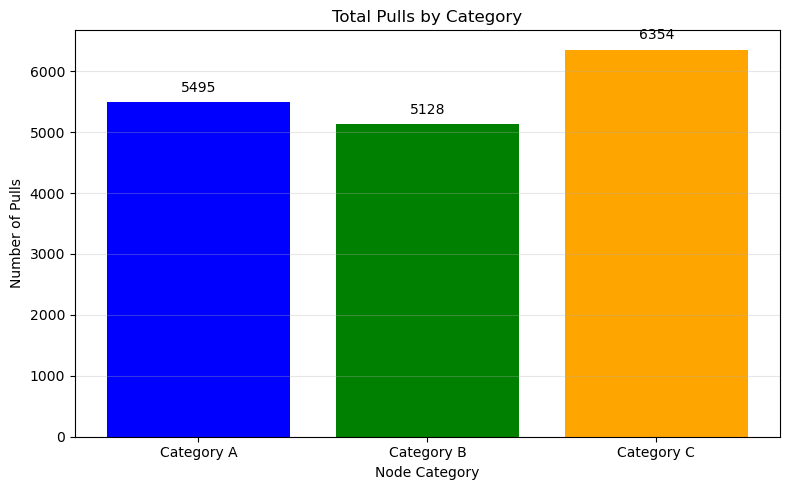

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.5
M = 2  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0} 

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0 (doesn't affect the first calculation)
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Calculate AoII
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Calculate Whittle index as q_passive - q_active
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Select only nodes with positive Whittle indices
        positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
        
        # Step 3: If we have more than M positive nodes, take the top M
        if len(positive_nodes) > M:
            # Sort by Whittle index in descending order and take top M
            nodes_to_poll = sorted(positive_nodes, key=lambda col: whittle_indices[col], reverse=True)[:M]
            
            # Update the dynamic penalty to be the Whittle index of the M-th node
            Mth_node = nodes_to_poll[-1]
            aoii_penalty = max(0, whittle_indices[Mth_node])  # Ensure non-negative penalty
        else:
            # If we have fewer than M positive nodes, take all of them
            nodes_to_poll = positive_nodes
            
            # Set penalty to 0 as we couldn't fill our M slots
            aoii_penalty = 0.0
        
        # Record the penalty value
        penalty_values.append(aoii_penalty)
        
        # Record how many nodes we're polling at this time step
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward_value  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1
             
        # Step 5: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, penalty_values, nodes_polled_count

# Run the simulation with dynamic penalty
cumulative_rewards_whittle, category_pulled_counts, penalty_values, nodes_polled_count = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Calculate total pulls
total_pulls = sum(category_pulled_counts.values())
print(f"Total number of pulls: {total_pulls}")

# Calculate statistics about the penalty values and nodes polled
avg_penalty = np.mean(penalty_values)
max_penalty = np.max(penalty_values)
min_penalty = np.min(penalty_values)
avg_nodes_polled = np.mean(nodes_polled_count)
max_nodes_polled = np.max(nodes_polled_count)
min_nodes_polled = np.min(nodes_polled_count)

print(f"\nDynamic Penalty Statistics:")
print(f"Average Penalty: {avg_penalty:.4f}")
print(f"Maximum Penalty: {max_penalty:.4f}")
print(f"Minimum Penalty: {min_penalty:.4f}")

print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.4f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Minimum Nodes Polled at any Time Step: {min_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_dynamic_penalty.csv", index=False
)

# Plot total pulls by category
categories = list(category_pulled_counts.keys())
counts = list(category_pulled_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'green', 'orange'])
plt.title('Total Pulls by Category')
plt.xlabel('Node Category')
plt.ylabel('Number of Pulls')
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + (total_pulls * 0.01), str(count), ha='center')

plt.tight_layout()
plt.savefig('category_pulls.png', dpi=300, bbox_inches='tight')

Transmission Count by Category:
Category A: 4549 times
Category B: 6169 times
Category C: 10864 times
Total number of pulls: 21582

Dynamic Penalty Statistics:
Average Penalty: 0.2738
Maximum Penalty: 0.3829
Minimum Penalty: 0.0000

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 2.1582
Maximum Nodes Polled at any Time Step: 5
Minimum Nodes Polled at any Time Step: 0
Target Maximum (M): 5


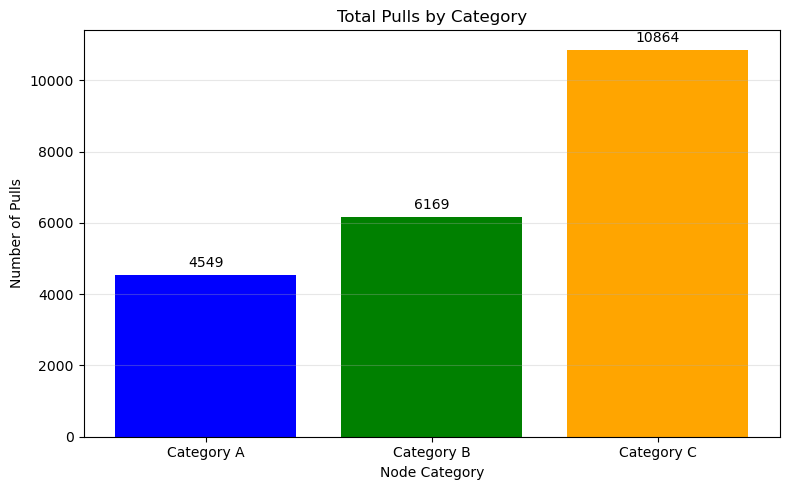

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.5
M = 5 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0} 

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0 (doesn't affect the first calculation)
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Calculate AoII
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Calculate Whittle index as q_passive - q_active
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Select only nodes with positive Whittle indices
        positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
        
        # Step 3: If we have more than M positive nodes, take the top M
        if len(positive_nodes) > M:
            # Sort by Whittle index in descending order and take top M
            nodes_to_poll = sorted(positive_nodes, key=lambda col: whittle_indices[col], reverse=True)[:M]
            
            # Update the dynamic penalty to be the Whittle index of the M-th node
            Mth_node = nodes_to_poll[-1]
            aoii_penalty = max(0, whittle_indices[Mth_node])  # Ensure non-negative penalty
        else:
            # If we have fewer than M positive nodes, take all of them
            nodes_to_poll = positive_nodes
            
            # Maintain current penalty if we couldn't fill our M slots
            # This allows AoII to accumulate over time until more nodes become eligible
            # (penalty remains unchanged from previous iteration)
        
        # Record the penalty value
        penalty_values.append(aoii_penalty)
        
        # Record how many nodes we're polling at this time step
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward_value  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1
             
        # Step 5: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, penalty_values, nodes_polled_count

# Run the simulation with dynamic penalty
cumulative_rewards_whittle, category_pulled_counts, penalty_values, nodes_polled_count = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Calculate total pulls
total_pulls = sum(category_pulled_counts.values())
print(f"Total number of pulls: {total_pulls}")

# Calculate statistics about the penalty values and nodes polled
avg_penalty = np.mean(penalty_values)
max_penalty = np.max(penalty_values)
min_penalty = np.min(penalty_values)
avg_nodes_polled = np.mean(nodes_polled_count)
max_nodes_polled = np.max(nodes_polled_count)
min_nodes_polled = np.min(nodes_polled_count)

print(f"\nDynamic Penalty Statistics:")
print(f"Average Penalty: {avg_penalty:.4f}")
print(f"Maximum Penalty: {max_penalty:.4f}")
print(f"Minimum Penalty: {min_penalty:.4f}")

print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.4f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Minimum Nodes Polled at any Time Step: {min_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_dynamic_penalty.csv", index=False
)

# Plot total pulls by category
categories = list(category_pulled_counts.keys())
counts = list(category_pulled_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'green', 'orange'])
plt.title('Total Pulls by Category')
plt.xlabel('Node Category')
plt.ylabel('Number of Pulls')
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + (total_pulls * 0.01), str(count), ha='center')

plt.tight_layout()
plt.savefig('category_pulls.png', dpi=300, bbox_inches='tight')

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")

pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
reward = 0.5
M = 2  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled in each phase
phase1_counts = {'Category A': 0, 'Category B': 0}
phase2_counts = {'Category A': 0, 'Category B': 0}
total_counts = {'Category A': 0, 'Category B': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Get only positive Whittle indices
    positive_indices = [v for v in whittle_indices.values() if v > 0]
    
    # If there are fewer than M positive nodes, keep current penalty
    if len(positive_indices) <= M:
        return current_lambda
    
    # Sort the positive values in descending order
    sorted_indices = sorted(positive_indices, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_indices[M-1]
    
    # Update penalty to the M-th value
    new_lambda = max(0, M_th_value)  # Ensure non-negative
    
    return new_lambda

# Main function to simulate Whittle AoII with dynamic penalty and track transmission counts by phase
def run_simulation_whittle_aoii_positive_indices(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Track penalty values by phase
    phase1_penalty_values = []
    phase2_penalty_values = []
    
    # Track nodes polled by phase
    phase1_nodes_polled = []
    phase2_nodes_polled = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current phase
        current_phase = 1 if t < 5000 else 2
        
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Calculate AoII
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Calculate Whittle index
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Track penalty by phase
        if current_phase == 1:
            phase1_penalty_values.append(aoii_penalty)
        else:
            phase2_penalty_values.append(aoii_penalty)
        
        # Step 3: Select only nodes with positive Whittle indices
        positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
        
        # Step 4: If we have more than M positive nodes, take the top M
        if len(positive_nodes) > M:
            # Sort by Whittle index in descending order and take top M
            nodes_to_poll = sorted(positive_nodes, key=lambda col: whittle_indices[col], reverse=True)[:M]
        else:
            # If we have fewer than M positive nodes, take all of them
            nodes_to_poll = positive_nodes
        
        # Track number of nodes polled
        nodes_polled = len(nodes_to_poll)
        nodes_polled_count.append(nodes_polled)
        
        # Track nodes polled by phase
        if current_phase == 1:
            phase1_nodes_polled.append(nodes_polled)
        else:
            phase2_nodes_polled.append(nodes_polled)

        # Step 5: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward_value = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward_value  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                category = get_node_category(node_id)
                if category:
                    # Increment appropriate counter based on phase
                    if current_phase == 1:
                        phase1_counts[category] += 1
                    else:
                        phase2_counts[category] += 1
                    
                    # Increment total counter
                    total_counts[category] += 1

        # Step 6: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    # Compile phase-specific statistics
    phase_stats = {
        'phase1': {
            'avg_penalty': np.mean(phase1_penalty_values) if phase1_penalty_values else 0,
            'max_penalty': np.max(phase1_penalty_values) if phase1_penalty_values else 0,
            'min_penalty': np.min(phase1_penalty_values) if phase1_penalty_values else 0,
            'avg_nodes_polled': np.mean(phase1_nodes_polled) if phase1_nodes_polled else 0,
            'max_nodes_polled': np.max(phase1_nodes_polled) if phase1_nodes_polled else 0
        },
        'phase2': {
            'avg_penalty': np.mean(phase2_penalty_values) if phase2_penalty_values else 0,
            'max_penalty': np.max(phase2_penalty_values) if phase2_penalty_values else 0,
            'min_penalty': np.min(phase2_penalty_values) if phase2_penalty_values else 0,
            'avg_nodes_polled': np.mean(phase2_nodes_polled) if phase2_nodes_polled else 0,
            'max_nodes_polled': np.max(phase2_nodes_polled) if phase2_nodes_polled else 0
        },
        'total': {
            'avg_penalty': np.mean(penalty_values),
            'max_penalty': np.max(penalty_values),
            'min_penalty': np.min(penalty_values),
            'avg_nodes_polled': np.mean(nodes_polled_count),
            'max_nodes_polled': np.max(nodes_polled_count)
        }
    }

    return cumulative_rewards, phase1_counts, phase2_counts, total_counts, phase_stats

# Run the simulation with positive Whittle indices
cumulative_rewards_whittle, phase1_counts, phase2_counts, total_counts, phase_stats = run_simulation_whittle_aoii_positive_indices(
    pivot_df, columns, M, theta, penalty
)

# Print phase-specific transmission counts
print("\nPhase 1 Transmission Count by Category:")
phase1_total = sum(phase1_counts.values())
for category, count in phase1_counts.items():
    percentage = (count / phase1_total * 100) if phase1_total > 0 else 0
    print(f"{category}: {count} times ({percentage:.1f}%)")

print("\nPhase 2 Transmission Count by Category:")
phase2_total = sum(phase2_counts.values())
for category, count in phase2_counts.items():
    percentage = (count / phase2_total * 100) if phase2_total > 0 else 0
    print(f"{category}: {count} times ({percentage:.1f}%)")

print("\nTotal Transmission Count by Category:")
total_transmissions = sum(total_counts.values())
for category, count in total_counts.items():
    percentage = (count / total_transmissions * 100) if total_transmissions > 0 else 0
    print(f"{category}: {count} times ({percentage:.1f}%)")

# Print phase-specific statistics
print("\nPhase 1 Statistics:")
print(f"Average Penalty: {phase_stats['phase1']['avg_penalty']:.4f}")
print(f"Maximum Penalty: {phase_stats['phase1']['max_penalty']:.4f}")
print(f"Minimum Penalty: {phase_stats['phase1']['min_penalty']:.4f}")
print(f"Average Nodes Polled: {phase_stats['phase1']['avg_nodes_polled']:.4f}")
print(f"Maximum Nodes Polled: {phase_stats['phase1']['max_nodes_polled']}")

print("\nPhase 2 Statistics:")
print(f"Average Penalty: {phase_stats['phase2']['avg_penalty']:.4f}")
print(f"Maximum Penalty: {phase_stats['phase2']['max_penalty']:.4f}")
print(f"Minimum Penalty: {phase_stats['phase2']['min_penalty']:.4f}")
print(f"Average Nodes Polled: {phase_stats['phase2']['avg_nodes_polled']:.4f}")
print(f"Maximum Nodes Polled: {phase_stats['phase2']['max_nodes_polled']}")

print("\nOverall Statistics:")
print(f"Average Penalty: {phase_stats['total']['avg_penalty']:.4f}")
print(f"Maximum Penalty: {phase_stats['total']['max_penalty']:.4f}")
print(f"Minimum Penalty: {phase_stats['total']['min_penalty']:.4f}")
print(f"Average Nodes Polled: {phase_stats['total']['avg_nodes_polled']:.4f}")
print(f"Maximum Nodes Polled: {phase_stats['total']['max_nodes_polled']}")
print(f"Target Maximum (M): {M}")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_positive_indices.csv", index=False
)


Phase 1 Transmission Count by Category:
Category A: 2746 times (99.1%)
Category B: 25 times (0.9%)

Phase 2 Transmission Count by Category:
Category A: 26 times (100.0%)
Category B: 0 times (0.0%)

Total Transmission Count by Category:
Category A: 2772 times (99.1%)
Category B: 25 times (0.9%)

Phase 1 Statistics:
Average Penalty: 0.1332
Maximum Penalty: 0.3000
Minimum Penalty: 0.0042
Average Nodes Polled: 0.5542
Maximum Nodes Polled: 2

Phase 2 Statistics:
Average Penalty: 0.1791
Maximum Penalty: 0.1791
Minimum Penalty: 0.1791
Average Nodes Polled: 0.0052
Maximum Nodes Polled: 1

Overall Statistics:
Average Penalty: 0.1562
Maximum Penalty: 0.3000
Minimum Penalty: 0.0000
Average Nodes Polled: 0.2797
Maximum Nodes Polled: 2
Target Maximum (M): 2


In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")

pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.5
M = 1 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.99  # dEWMA parameter for state value
beta_2 = 0.99 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    # Initialize storage for MSE calculation
    true_values = {col: [] for col in columns}
    predicted_values = {col: [] for col in columns}

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Store true value for all nodes at each time step
            true_values[col].append(measured_value)
            
            # Generate prediction for current time using the last known state
            delta_t_for_prediction = max(min_delta_t, t - last_update_times[col])
            predicted_value = last_state_value + last_rate_of_change * delta_t_for_prediction
            predicted_values[col].append(predicted_value)

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 5:
                    category_counts['Category A'] += 1
                elif 6 <= node_id <= 10:
                    category_counts['Category B'] += 1
             
        # Step 5: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards, category_counts, penalty_values, nodes_polled_count, true_values, predicted_values

# Run the simulation with dynamic penalty
cumulative_rewards_whittle, category_pulled_counts, penalty_values, nodes_polled_count, true_values, predicted_values = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv(
    "cumulative_rewards_whittle_dynamic_penalty.csv", index=False
)

# Calculate statistics about the penalty values and nodes polled
avg_penalty = np.mean(penalty_values)
max_penalty = np.max(penalty_values)
min_penalty = np.min(penalty_values)
avg_nodes_polled = np.mean(nodes_polled_count)
max_nodes_polled = np.max(nodes_polled_count)

print(f"\nDynamic Penalty Statistics:")
print(f"Average Penalty: {avg_penalty:.4f}")
print(f"Maximum Penalty: {max_penalty:.4f}")
print(f"Minimum Penalty: {min_penalty:.4f}")
print(f"\nNodes Polled Statistics:")
print(f"Average Nodes Polled per Time Step: {avg_nodes_polled:.2f}")
print(f"Maximum Nodes Polled at any Time Step: {max_nodes_polled}")
print(f"Target Maximum (M): {M}")

# Calculate MSE for each node
node_mse = {}
for col in columns:
    # Handle potential NaN values
    pred_array = np.array(predicted_values[col])
    true_array = np.array(true_values[col])
    
    # Create mask for non-NaN values
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array)
    
    # Only calculate MSE with valid values
    if np.any(valid_mask):
        node_mse[col] = mean_squared_error(
            true_array[valid_mask], 
            pred_array[valid_mask]
        )
    else:
        node_mse[col] = np.nan

# Calculate total MSE across all nodes
all_true_values = []
all_predicted_values = []

for col in columns:
    # Get arrays for this column
    pred_array = np.array(predicted_values[col])
    true_array = np.array(true_values[col])
    
    # Filter out NaN values
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array)
    
    # Add valid values to the combined arrays
    all_true_values.extend(true_array[valid_mask])
    all_predicted_values.extend(pred_array[valid_mask])

# Calculate overall MSE if we have valid data
if all_true_values and all_predicted_values:
    total_mse = mean_squared_error(all_true_values, all_predicted_values)
    print(f"\nTotal MSE: {total_mse:.6f}")
else:
    print("\nUnable to calculate Total MSE: No valid data points")

# Calculate MSE per category
category_mse = {'Category A': [], 'Category B': []}
for col in columns:
    node_id = extract_node_id(col)
    category = get_node_category(node_id)
    if category and not np.isnan(node_mse[col]):
        category_mse[category].append(node_mse[col])

# Print MSE per category
print("\nMSE by Category:")
for category, mse_values in category_mse.items():
    if mse_values:
        avg_mse = np.mean(mse_values)
        print(f"{category}: {avg_mse:.6f}")
    else:
        print(f"{category}: No valid data for MSE calculation")

Transmission Count by Category:
Category A: 604 times
Category B: 18 times

Dynamic Penalty Statistics:
Average Penalty: 0.5225
Maximum Penalty: 0.6829
Minimum Penalty: 0.0000

Nodes Polled Statistics:
Average Nodes Polled per Time Step: 0.06
Maximum Nodes Polled at any Time Step: 10
Target Maximum (M): 1

Total MSE: 10.957372

MSE by Category:
Category A: 21.725755
Category B: 0.188989


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps


M = 1  # Maximum number of nodes that can be polled
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2


# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii(pivot_df, columns, M, aoii_penalty):
    
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 5:
                    category_counts['Category A'] += 1
                elif 6 <= node_id <= 10:
                    category_counts['Category B'] += 1


    return  category_counts

# Run the simulation
category_pulled_counts = run_simulation_whittle_aoii(
    pivot_df, columns, M, aoii_penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")



Transmission Count by Category:
Category A: 977 times
Category B: 1066 times


In [183]:
import pandas as pd
import numpy as np

# Load data
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
M = 2  # Maximum number of nodes that can be polled
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# dEWMA parameters
beta_1 = 0.8  # dEWMA parameter for state value
beta_2 = 0.3  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is pulled in each phase
phase1_counts = {'Category A': 0, 'Category B': 0}
phase2_counts = {'Category A': 0, 'Category B': 0}
total_counts = {'Category A': 0, 'Category B': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change
        
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract node ID
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Main simulation function
def run_simulation_whittle_aoii(pivot_df, columns, M, aoii_penalty):
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    min_delta_t = 1  # Minimum time difference to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current phase (1: t < 5000, 2: t >= 5000)
        current_phase = 1 if t < 5000 else 2
        
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate AoII values
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and update states
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1, beta_2
            )
            last_update_times[col] = t

            # Track category counts by phase
            node_id = extract_node_id(col)
            if node_id is not None:
                category = get_node_category(node_id)
                if category:
                    # Update phase-specific counter
                    if current_phase == 1:
                        phase1_counts[category] += 1
                    else:
                        phase2_counts[category] += 1
                    
                    # Update total counter
                    total_counts[category] += 1

    return phase1_counts, phase2_counts, total_counts

# Run the simulation
phase1_counts, phase2_counts, total_counts = run_simulation_whittle_aoii(
    pivot_df, columns, M, aoii_penalty
)

# Print the transmission counts by category for each phase
print("Phase 1 (t=1 to t=5000) Transmission Count by Category:")
total_phase1 = sum(phase1_counts.values())
for category, count in phase1_counts.items():
    print(f"{category}: {count} times ({count/total_phase1*100:.1f}%)")

print("\nPhase 2 (t=5001 to t=10000) Transmission Count by Category:")
total_phase2 = sum(phase2_counts.values())
for category, count in phase2_counts.items():
    print(f"{category}: {count} times ({count/total_phase2*100:.1f}%)")

print("\nTotal Transmission Count by Category:")
total_overall = sum(total_counts.values())
for category, count in total_counts.items():
    print(f"{category}: {count} times ({count/total_overall*100:.1f}%)")

# Print summary of the phase shift
print("\n--- Phase Shift Analysis ---")
print(f"In Phase 1, Category A was polled {phase1_counts['Category A']/phase1_counts['Category B']:.2f}x more than Category B")
print(f"In Phase 2, Category B was polled {phase2_counts['Category B']/phase2_counts['Category A']:.2f}x more than Category A")

Phase 1 (t=1 to t=5000) Transmission Count by Category:
Category A: 594 times (67.0%)
Category B: 293 times (33.0%)

Phase 2 (t=5001 to t=10000) Transmission Count by Category:
Category A: 100 times (61.0%)
Category B: 64 times (39.0%)

Total Transmission Count by Category:
Category A: 694 times (66.0%)
Category B: 357 times (34.0%)

--- Phase Shift Analysis ---
In Phase 1, Category A was polled 2.03x more than Category B
In Phase 2, Category B was polled 0.64x more than Category A


In [ ]:
import pandas as pd
import numpy as np

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
reward = 0.5
M = 1  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9 # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Define time windows (every 1000 time steps)
window_size = 1000
num_windows = num_time_steps // window_size
window_names = [f"t={i*window_size+1}-{(i+1)*window_size}" for i in range(num_windows)]

# Track counts per window
window_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Track fairness-triggered polls
fairness_poll_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 10:
        return 'Category A'
    elif 11 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Dynamic Penalty Update algorithm
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Helper function to poll a node and update state
def poll_node(col, t, measured_value, state_node, last_update_times, is_fairness_poll=False):
    last_state_value, last_rate_of_change = state_node[col]
    
    # Get min_delta_t to avoid division by zero
    min_delta_t = 1
    delta_t_dynamic = max(min_delta_t, t - last_update_times[col])
    
    # Update node state and last update time
    state_node[col] = update_node_state_dewma(
        measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
    )
    last_update_times[col] = t
    
    # Track category of polled node
    node_id = extract_node_id(col)
    if node_id is not None:
        category = get_node_category(node_id)
        current_window = t // window_size
        
        if category:
            # Update appropriate counter
            if is_fairness_poll:
                fairness_poll_counts[current_window][category] += 1
            
            # Update total counter regardless of poll type
            window_counts[current_window][category] += 1
    
    return state_node, last_update_times

# Main function to simulate Whittle AoII with fairness mechanism
def run_simulation_with_fairness(pivot_df, columns, M, theta, penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution by window
    window_penalties = [[] for _ in range(num_windows)]
    
    # Track nodes polled in each window
    window_nodes_polled = [[] for _ in range(num_windows)]
    window_fairness_polled = [[] for _ in range(num_windows)]
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current window
        current_window = t // window_size
        
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            window_fairness_polled[current_window].append(len(fairness_polls))
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times, 
                    is_fairness_poll=True
                )
        else:
            window_fairness_polled[current_window].append(0)
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]

                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled

                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                
                whittle_index = q_passive - q_active
                
                # Handle NaN or Inf values
                if np.isnan(whittle_index) or np.isinf(whittle_index):
                    whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
                else:
                    whittle_indices[col] = whittle_index

            # Update the dynamic penalty (λ)
            aoii_penalty = dynamic_penalty_update(whittle_indices, remaining_slots, aoii_penalty)
            window_penalties[current_window].append(aoii_penalty)
            
            # Select nodes to poll based on updated penalty
            nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
            if len(nodes_to_poll) > remaining_slots:
                nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:remaining_slots]
            
            window_nodes_polled[current_window].append(len(fairness_polls) + len(nodes_to_poll))
            
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times
                )
        else:
            window_penalties[current_window].append(aoii_penalty)
            window_nodes_polled[current_window].append(len(fairness_polls))

    # Calculate window statistics
    window_stats = []
    for i in range(num_windows):
        total_polled = sum(window_counts[i].values())
        fairness_polled = sum(fairness_poll_counts[i].values())
        
        category_a_pct = (window_counts[i]['Category A'] / total_polled * 100) if total_polled > 0 else 0
        category_b_pct = (window_counts[i]['Category B'] / total_polled * 100) if total_polled > 0 else 0
        
        fairness_a_pct = (fairness_poll_counts[i]['Category A'] / fairness_polled * 100) if fairness_polled > 0 else 0
        fairness_b_pct = (fairness_poll_counts[i]['Category B'] / fairness_polled * 100) if fairness_polled > 0 else 0
        
        avg_penalty = np.mean(window_penalties[i]) if window_penalties[i] else 0
        avg_nodes_polled = np.mean(window_nodes_polled[i]) if window_nodes_polled[i] else 0
        avg_fairness_polled = np.mean(window_fairness_polled[i]) if window_fairness_polled[i] else 0
        
        window_stats.append({
            'window': window_names[i],
            'Category A': window_counts[i]['Category A'],
            'Category B': window_counts[i]['Category B'],
            'Category A %': category_a_pct,
            'Category B %': category_b_pct,
            'Total Polled': total_polled,
            'Fairness A': fairness_poll_counts[i]['Category A'],
            'Fairness B': fairness_poll_counts[i]['Category B'],
            'Fairness A %': fairness_a_pct,
            'Fairness B %': fairness_b_pct,
            'Total Fairness': fairness_polled,
            'Fairness %': (fairness_polled / total_polled * 100) if total_polled > 0 else 0,
            'Avg Penalty': avg_penalty,
            'Avg Nodes Polled': avg_nodes_polled,
            'Avg Fairness Polled': avg_fairness_polled
        })

    return window_stats, window_counts, fairness_poll_counts

# Run the simulation with fairness mechanism
window_stats, window_counts, fairness_poll_counts = run_simulation_with_fairness(
    pivot_df, columns, M, theta, penalty, L, fairness_window
)

# Print detailed window statistics
print(f"Fairness Configuration: Check every {L} timesteps, Window size: {fairness_window}")
print("\nPolling Distribution by Time Window:")
print("----------------------------------")
for i, stats in enumerate(window_stats):
    print(f"\nWindow {i+1}: {stats['window']}")
    print(f"Category A: {stats['Category A']} times ({stats['Category A %']:.1f}%)")
    print(f"Category B: {stats['Category B']} times ({stats['Category B %']:.1f}%)")
    print(f"Total Polled: {stats['Total Polled']}")
    print(f"Fairness-triggered polls: {stats['Total Fairness']} ({stats['Fairness %']:.1f}% of total)")
    print(f"   - Category A: {stats['Fairness A']} ({stats['Fairness A %']:.1f}% of fairness)")
    print(f"   - Category B: {stats['Fairness B']} ({stats['Fairness B %']:.1f}% of fairness)")
    print(f"Average Penalty: {stats['Avg Penalty']:.4f}")
    print(f"Average Nodes Polled: {stats['Avg Nodes Polled']:.2f}")

# Print summary statistics in CSV-friendly format
print("\nWindow-by-Window Summary (CSV format):")
print("Window,Cat A,Cat B,Cat A %,Cat B %,Total,Fairness A,Fairness B,Fairness %,Avg Penalty,Avg Nodes Polled")
for stats in window_stats:
    print(f"{stats['window']},{stats['Category A']},{stats['Category B']},{stats['Category A %']:.1f},{stats['Category B %']:.1f},{stats['Total Polled']},{stats['Fairness A']},{stats['Fairness B']},{stats['Fairness %']:.1f},{stats['Avg Penalty']:.4f},{stats['Avg Nodes Polled']:.2f}")

# Print pre/post transition comparison
pre_transition = window_stats[:5]  # Windows 1-5 (before t=5000)
post_transition = window_stats[5:]  # Windows 6-10 (after t=5000)

pre_cat_a = sum(stats['Category A'] for stats in pre_transition)
pre_cat_b = sum(stats['Category B'] for stats in pre_transition)
pre_total = pre_cat_a + pre_cat_b

post_cat_a = sum(stats['Category A'] for stats in post_transition)
post_cat_b = sum(stats['Category B'] for stats in post_transition)
post_total = post_cat_a + post_cat_b

pre_fairness = sum(stats['Total Fairness'] for stats in pre_transition)
post_fairness = sum(stats['Total Fairness'] for stats in post_transition)

print("\nPre-Transition Summary (t=1-5000):")
print(f"Category A: {pre_cat_a} times ({pre_cat_a/pre_total*100:.1f}%)")
print(f"Category B: {pre_cat_b} times ({pre_cat_b/pre_total*100:.1f}%)")
print(f"Fairness-triggered polls: {pre_fairness} ({pre_fairness/pre_total*100:.1f}% of total)")

print("\nPost-Transition Summary (t=5001-10000):")
print(f"Category A: {post_cat_a} times ({post_cat_a/post_total*100:.1f}%)")
print(f"Category B: {post_cat_b} times ({post_cat_b/post_total*100:.1f}%)")
print(f"Fairness-triggered polls: {post_fairness} ({post_fairness/post_total*100:.1f}% of total)")

# Print observations about fairness mechanism
print("\nFairness Mechanism Impact:")
print(f"Total polls generated by fairness: {pre_fairness + post_fairness}")
print(f"Percentage of all polling due to fairness: {(pre_fairness + post_fairness)/(pre_total + post_total)*100:.1f}%")

if post_cat_b > post_cat_a and (post_fairness/post_total*100) > 50:
    print("Observation: The fairness mechanism was critical in detecting the trend reversal after t=5000")
    print(f"Post-transition fairness polling accounted for {post_fairness/post_total*100:.1f}% of all polls")

Fairness Configuration: Check every 100 timesteps, Window size: 500

Polling Distribution by Time Window:
----------------------------------

Window 1: t=1-1000
Category A: 20 times (50.0%)
Category B: 20 times (50.0%)
Total Polled: 40
Fairness-triggered polls: 0 (0.0% of total)
   - Category A: 0 (0.0% of fairness)
   - Category B: 0 (0.0% of fairness)
Average Penalty: 1.8729
Average Nodes Polled: 0.16

Window 2: t=1001-2000
Category A: 8 times (72.7%)
Category B: 3 times (27.3%)
Total Polled: 11
Fairness-triggered polls: 6 (54.5% of total)
   - Category A: 3 (50.0% of fairness)
   - Category B: 3 (50.0% of fairness)
Average Penalty: 2.0509
Average Nodes Polled: 0.07

Window 3: t=2001-3000
Category A: 5 times (71.4%)
Category B: 2 times (28.6%)
Total Polled: 7
Fairness-triggered polls: 2 (28.6% of total)
   - Category A: 0 (0.0% of fairness)
   - Category B: 2 (100.0% of fairness)
Average Penalty: 2.2036
Average Nodes Polled: 0.06

Window 4: t=3001-4000
Category A: 4 times (44.4%)
Cat

In [35]:
import pandas as pd
import numpy as np

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
reward = 0.5
M = 1  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Define time windows (every 1000 time steps)
window_size = 1000
num_windows = num_time_steps // window_size
window_names = [f"t={i*window_size+1}-{(i+1)*window_size}" for i in range(num_windows)]

# Track counts per window
window_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Track fairness-triggered polls
fairness_poll_counts = [{
    'Category A': 0,
    'Category B': 0
} for _ in range(num_windows)]

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category - Fixed to correctly classify Category B
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 11:  # Fixed the upper bound to correctly identify Category B
        return 'Category B'
    else:
        return None

# Dynamic Penalty Update algorithm (kept for tracking purposes)
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Get only positive Whittle indices
    positive_indices = [v for v in whittle_indices.values() if v > 0]
    
    # If there are fewer than M positive nodes, keep current penalty
    if len(positive_indices) <= M:
        return current_lambda
    
    # Sort the positive values in descending order
    sorted_indices = sorted(positive_indices, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_indices[M-1]
    
    # Update penalty to the M-th value
    new_lambda = max(0, M_th_value)  # Ensure non-negative
    
    return new_lambda

# Helper function to poll a node and update state
def poll_node(col, t, measured_value, state_node, last_update_times, is_fairness_poll=False):
    last_state_value, last_rate_of_change = state_node[col]
    
    # Get min_delta_t to avoid division by zero
    min_delta_t = 1
    delta_t_dynamic = max(min_delta_t, t - last_update_times[col])
    
    # Update node state and last update time
    state_node[col] = update_node_state_dewma(
        measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
    )
    last_update_times[col] = t
    
    # Track category of polled node
    node_id = extract_node_id(col)
    if node_id is not None:
        category = get_node_category(node_id)
        current_window = t // window_size
        
        if category:
            # Update appropriate counter
            if is_fairness_poll:
                fairness_poll_counts[current_window][category] += 1
            
            # Update total counter regardless of poll type
            window_counts[current_window][category] += 1
    
    return state_node, last_update_times

# Main function to simulate Whittle AoII with fairness mechanism
def run_simulation_with_fairness(pivot_df, columns, M, theta, penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution by window
    window_penalties = [[] for _ in range(num_windows)]
    
    # Track nodes polled in each window
    window_nodes_polled = [[] for _ in range(num_windows)]
    window_fairness_polled = [[] for _ in range(num_windows)]
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current window
        current_window = t // window_size
        
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            window_fairness_polled[current_window].append(len(fairness_polls))
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times, 
                    is_fairness_poll=True
                )
        else:
            window_fairness_polled[current_window].append(0)
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]

                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled

                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                
                whittle_index = q_passive - q_active
                
                # Handle NaN or Inf values
                if np.isnan(whittle_index) or np.isinf(whittle_index):
                    whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
                else:
                    whittle_indices[col] = whittle_index

            # Update the dynamic penalty (λ) for tracking purposes
            aoii_penalty = dynamic_penalty_update(whittle_indices, remaining_slots, aoii_penalty)
            window_penalties[current_window].append(aoii_penalty)
            
            # MODIFIED: Select nodes with positive Whittle indices
            positive_nodes = [col for col in whittle_indices if whittle_indices[col] > 0]
            
            # If we have more than remaining_slots positive nodes, take the top ones
            if len(positive_nodes) > remaining_slots:
                # Sort by Whittle index in descending order and take top remaining_slots
                nodes_to_poll = sorted(positive_nodes, 
                                      key=lambda col: whittle_indices[col], 
                                      reverse=True)[:remaining_slots]
            else:
                # If we have fewer than remaining_slots positive nodes, take all of them
                nodes_to_poll = positive_nodes
            
            window_nodes_polled[current_window].append(len(fairness_polls) + len(nodes_to_poll))
            
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times
                )
        else:
            window_penalties[current_window].append(aoii_penalty)
            window_nodes_polled[current_window].append(len(fairness_polls))

    # Calculate window statistics
    window_stats = []
    for i in range(num_windows):
        total_polled = sum(window_counts[i].values())
        fairness_polled = sum(fairness_poll_counts[i].values())
        
        category_a_pct = (window_counts[i]['Category A'] / total_polled * 100) if total_polled > 0 else 0
        category_b_pct = (window_counts[i]['Category B'] / total_polled * 100) if total_polled > 0 else 0
        
        fairness_a_pct = (fairness_poll_counts[i]['Category A'] / fairness_polled * 100) if fairness_polled > 0 else 0
        fairness_b_pct = (fairness_poll_counts[i]['Category B'] / fairness_polled * 100) if fairness_polled > 0 else 0
        
        avg_penalty = np.mean(window_penalties[i]) if window_penalties[i] else 0
        avg_nodes_polled = np.mean(window_nodes_polled[i]) if window_nodes_polled[i] else 0
        avg_fairness_polled = np.mean(window_fairness_polled[i]) if window_fairness_polled[i] else 0
        
        window_stats.append({
            'window': window_names[i],
            'Category A': window_counts[i]['Category A'],
            'Category B': window_counts[i]['Category B'],
            'Category A %': category_a_pct,
            'Category B %': category_b_pct,
            'Total Polled': total_polled,
            'Fairness A': fairness_poll_counts[i]['Category A'],
            'Fairness B': fairness_poll_counts[i]['Category B'],
            'Fairness A %': fairness_a_pct,
            'Fairness B %': fairness_b_pct,
            'Total Fairness': fairness_polled,
            'Fairness %': (fairness_polled / total_polled * 100) if total_polled > 0 else 0,
            'Avg Penalty': avg_penalty,
            'Avg Nodes Polled': avg_nodes_polled,
            'Avg Fairness Polled': avg_fairness_polled
        })

    return window_stats, window_counts, fairness_poll_counts

# Run the simulation with fairness mechanism
window_stats, window_counts, fairness_poll_counts = run_simulation_with_fairness(
    pivot_df, columns, M, theta, penalty, L, fairness_window
)

# Print detailed window statistics
print(f"Fairness Configuration: Check every {L} timesteps, Window size: {fairness_window}")
print("\nPolling Distribution by Time Window:")
print("----------------------------------")
for i, stats in enumerate(window_stats):
    print(f"\nWindow {i+1}: {stats['window']}")
    print(f"Category A: {stats['Category A']} times ({stats['Category A %']:.1f}%)")
    print(f"Category B: {stats['Category B']} times ({stats['Category B %']:.1f}%)")
    print(f"Total Polled: {stats['Total Polled']}")
    print(f"Fairness-triggered polls: {stats['Total Fairness']} ({stats['Fairness %']:.1f}% of total)")
    print(f"   - Category A: {stats['Fairness A']} ({stats['Fairness A %']:.1f}% of fairness)")
    print(f"   - Category B: {stats['Fairness B']} ({stats['Fairness B %']:.1f}% of fairness)")
    print(f"Average Penalty: {stats['Avg Penalty']:.4f}")
    print(f"Average Nodes Polled: {stats['Avg Nodes Polled']:.2f}")

# Print summary statistics in CSV-friendly format
print("\nWindow-by-Window Summary (CSV format):")
print("Window,Cat A,Cat B,Cat A %,Cat B %,Total,Fairness A,Fairness B,Fairness %,Avg Penalty,Avg Nodes Polled")
for stats in window_stats:
    print(f"{stats['window']},{stats['Category A']},{stats['Category B']},{stats['Category A %']:.1f},{stats['Category B %']:.1f},{stats['Total Polled']},{stats['Fairness A']},{stats['Fairness B']},{stats['Fairness %']:.1f},{stats['Avg Penalty']:.4f},{stats['Avg Nodes Polled']:.2f}")

# Print pre/post transition comparison
pre_transition = window_stats[:5]  # Windows 1-5 (before t=5000)
post_transition = window_stats[5:]  # Windows 6-10 (after t=5000)

pre_cat_a = sum(stats['Category A'] for stats in pre_transition)
pre_cat_b = sum(stats['Category B'] for stats in pre_transition)
pre_total = pre_cat_a + pre_cat_b

post_cat_a = sum(stats['Category A'] for stats in post_transition)
post_cat_b = sum(stats['Category B'] for stats in post_transition)
post_total = post_cat_a + post_cat_b

pre_fairness = sum(stats['Total Fairness'] for stats in pre_transition)
post_fairness = sum(stats['Total Fairness'] for stats in post_transition)

print("\nPre-Transition Summary (t=1-5000):")
print(f"Category A: {pre_cat_a} times ({pre_cat_a/pre_total*100:.1f}%)")
print(f"Category B: {pre_cat_b} times ({pre_cat_b/pre_total*100:.1f}%)")
print(f"Fairness-triggered polls: {pre_fairness} ({pre_fairness/pre_total*100:.1f}% of total)")

print("\nPost-Transition Summary (t=5001-10000):")
print(f"Category A: {post_cat_a} times ({post_cat_a/post_total*100:.1f}%)")
print(f"Category B: {post_cat_b} times ({post_cat_b/post_total*100:.1f}%)")
print(f"Fairness-triggered polls: {post_fairness} ({post_fairness/post_total*100:.1f}% of total)")

# Print observations about fairness mechanism
print("\nFairness Mechanism Impact:")
print(f"Total polls generated by fairness: {pre_fairness + post_fairness}")
print(f"Percentage of all polling due to fairness: {(pre_fairness + post_fairness)/(pre_total + post_total)*100:.1f}%")

if post_cat_b > post_cat_a and (post_fairness/post_total*100) > 50:
    print("Observation: The fairness mechanism was critical in detecting the trend reversal after t=5000")
    print(f"Post-transition fairness polling accounted for {post_fairness/post_total*100:.1f}% of all polls")

Fairness Configuration: Check every 100 timesteps, Window size: 500

Polling Distribution by Time Window:
----------------------------------

Window 1: t=1-1000
Category A: 172 times (91.0%)
Category B: 17 times (9.0%)
Total Polled: 189
Fairness-triggered polls: 4 (2.1% of total)
   - Category A: 1 (25.0% of fairness)
   - Category B: 3 (75.0% of fairness)
Average Penalty: 0.7785
Average Nodes Polled: 0.19

Window 2: t=1001-2000
Category A: 131 times (94.2%)
Category B: 8 times (5.8%)
Total Polled: 139
Fairness-triggered polls: 8 (5.8% of total)
   - Category A: 0 (0.0% of fairness)
   - Category B: 8 (100.0% of fairness)
Average Penalty: 0.8654
Average Nodes Polled: 0.14

Window 3: t=2001-3000
Category A: 57 times (87.7%)
Category B: 8 times (12.3%)
Total Polled: 65
Fairness-triggered polls: 10 (15.4% of total)
   - Category A: 2 (20.0% of fairness)
   - Category B: 8 (80.0% of fairness)
Average Penalty: 1.0596
Average Nodes Polled: 0.07

Window 4: t=3001-4000
Category A: 46 times (88

In [9]:
import pandas as pd
import numpy as np

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to 10000 time steps

# Parameters
reward = 0.5
M = 2  # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9 # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Fairness parameters
L = 100  # Force fairness check every L time steps
fairness_window = 500  # Consider nodes not polled in this window for fairness polling

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Define time windows (every 1000 time steps)
window_size = 1000
num_windows = num_time_steps // window_size
window_names = [f"t={i*window_size+1}-{(i+1)*window_size}" for i in range(num_windows)]

# Track counts per window - MODIFIED for three categories
window_counts = [{
    'Category A': 0,
    'Category B': 0,
    'Category C': 0
} for _ in range(num_windows)]

# Track fairness-triggered polls - MODIFIED for three categories
fairness_poll_counts = [{
    'Category A': 0,
    'Category B': 0,
    'Category C': 0
} for _ in range(num_windows)]

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward  # Reward
    return penalty  # Penalty

# Function to extract numeric node ID
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category - MODIFIED for three categories
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 10:
        return 'Category A'
    elif 11 <= node_id <= 20:
        return 'Category B'
    elif 21 <= node_id <= 30:  # Added new category range
        return 'Category C'
    else:
        return None

# Dynamic Penalty Update algorithm
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Helper function to poll a node and update state
def poll_node(col, t, measured_value, state_node, last_update_times, is_fairness_poll=False):
    last_state_value, last_rate_of_change = state_node[col]
    
    # Get min_delta_t to avoid division by zero
    min_delta_t = 1
    delta_t_dynamic = max(min_delta_t, t - last_update_times[col])
    
    # Update node state and last update time
    state_node[col] = update_node_state_dewma(
        measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
    )
    last_update_times[col] = t
    
    # Track category of polled node
    node_id = extract_node_id(col)
    if node_id is not None:
        category = get_node_category(node_id)
        current_window = t // window_size
        
        if category:
            # Update appropriate counter
            if is_fairness_poll:
                fairness_poll_counts[current_window][category] += 1
            
            # Update total counter regardless of poll type
            window_counts[current_window][category] += 1
    
    return state_node, last_update_times

# Main function to simulate Whittle AoII with fairness mechanism
def run_simulation_with_fairness(pivot_df, columns, M, theta, penalty, L, fairness_window):
    cumulative_reward = 0  # Track total cumulative reward
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution by window
    window_penalties = [[] for _ in range(num_windows)]
    
    # Track nodes polled in each window
    window_nodes_polled = [[] for _ in range(num_windows)]
    window_fairness_polled = [[] for _ in range(num_windows)]
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Determine current window
        current_window = t // window_size
        
        # Step 1: Fairness check (every L time steps)
        fairness_polls = []
        if t % L == 0:  # Every L time steps
            # Find nodes that haven't been polled recently
            neglected_nodes = []
            for col in columns:
                if t - last_update_times[col] > fairness_window:
                    neglected_nodes.append(col)
            
            # Sort by last update time (oldest first)
            neglected_nodes.sort(key=lambda col: last_update_times[col])
            
            # Take up to M nodes for fairness polling
            fairness_polls = neglected_nodes[:M]
            window_fairness_polled[current_window].append(len(fairness_polls))
            
            # Poll the fairness nodes
            for col in fairness_polls:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times, 
                    is_fairness_poll=True
                )
        else:
            window_fairness_polled[current_window].append(0)
        
        # Step 2: Regular Whittle index calculation and polling
        # Only consider nodes not already polled by fairness mechanism
        remaining_slots = M - len(fairness_polls)
        
        if remaining_slots > 0:
            whittle_indices = {}
            for col in columns:
                # Skip nodes already polled by fairness
                if col in fairness_polls:
                    continue
                    
                last_state_value, last_rate_of_change = state_node[col]
                measured_value = pivot_df.loc[t, col]

                # Calculate AoII
                current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
                future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
                future_aoii_active = 0  # AoII resets to 0 if polled

                # Whittle index calculations
                q_passive = current_aoii + future_aoii_passive
                q_active = current_aoii + future_aoii_active + aoii_penalty
                
                whittle_index = q_passive - q_active
                
                # Handle NaN or Inf values
                if np.isnan(whittle_index) or np.isinf(whittle_index):
                    whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
                else:
                    whittle_indices[col] = whittle_index

            # Update the dynamic penalty (λ)
            aoii_penalty = dynamic_penalty_update(whittle_indices, remaining_slots, aoii_penalty)
            window_penalties[current_window].append(aoii_penalty)
            
            # Select nodes to poll based on updated penalty
            nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
            if len(nodes_to_poll) > remaining_slots:
                nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:remaining_slots]
            
            window_nodes_polled[current_window].append(len(fairness_polls) + len(nodes_to_poll))
            
            # Poll the selected nodes
            for col in nodes_to_poll:
                measured_value = pivot_df.loc[t, col]
                state_node, last_update_times = poll_node(
                    col, t, measured_value, state_node, last_update_times
                )
        else:
            window_penalties[current_window].append(aoii_penalty)
            window_nodes_polled[current_window].append(len(fairness_polls))

    # Calculate window statistics - MODIFIED for three categories
    window_stats = []
    for i in range(num_windows):
        total_polled = sum(window_counts[i].values())
        fairness_polled = sum(fairness_poll_counts[i].values())
        
        # Calculate percentages for all three categories
        category_a_pct = (window_counts[i]['Category A'] / total_polled * 100) if total_polled > 0 else 0
        category_b_pct = (window_counts[i]['Category B'] / total_polled * 100) if total_polled > 0 else 0
        category_c_pct = (window_counts[i]['Category C'] / total_polled * 100) if total_polled > 0 else 0
        
        # Calculate fairness percentages for all three categories
        fairness_a_pct = (fairness_poll_counts[i]['Category A'] / fairness_polled * 100) if fairness_polled > 0 else 0
        fairness_b_pct = (fairness_poll_counts[i]['Category B'] / fairness_polled * 100) if fairness_polled > 0 else 0
        fairness_c_pct = (fairness_poll_counts[i]['Category C'] / fairness_polled * 100) if fairness_polled > 0 else 0
        
        avg_penalty = np.mean(window_penalties[i]) if window_penalties[i] else 0
        avg_nodes_polled = np.mean(window_nodes_polled[i]) if window_nodes_polled[i] else 0
        avg_fairness_polled = np.mean(window_fairness_polled[i]) if window_fairness_polled[i] else 0
        
        window_stats.append({
            'window': window_names[i],
            'Category A': window_counts[i]['Category A'],
            'Category B': window_counts[i]['Category B'],
            'Category C': window_counts[i]['Category C'],  # Added Category C
            'Category A %': category_a_pct,
            'Category B %': category_b_pct,
            'Category C %': category_c_pct,  # Added Category C percentage
            'Total Polled': total_polled,
            'Fairness A': fairness_poll_counts[i]['Category A'],
            'Fairness B': fairness_poll_counts[i]['Category B'],
            'Fairness C': fairness_poll_counts[i]['Category C'],  # Added Category C fairness
            'Fairness A %': fairness_a_pct,
            'Fairness B %': fairness_b_pct,
            'Fairness C %': fairness_c_pct,  # Added Category C fairness percentage
            'Total Fairness': fairness_polled,
            'Fairness %': (fairness_polled / total_polled * 100) if total_polled > 0 else 0,
            'Avg Penalty': avg_penalty,
            'Avg Nodes Polled': avg_nodes_polled,
            'Avg Fairness Polled': avg_fairness_polled
        })

    return window_stats, window_counts, fairness_poll_counts

# Run the simulation with fairness mechanism
window_stats, window_counts, fairness_poll_counts = run_simulation_with_fairness(
    pivot_df, columns, M, theta, penalty, L, fairness_window
)

# Print detailed window statistics - MODIFIED for three categories
print(f"Fairness Configuration: Check every {L} timesteps, Window size: {fairness_window}")
print("\nPolling Distribution by Time Window:")
print("----------------------------------")
for i, stats in enumerate(window_stats):
    print(f"\nWindow {i+1}: {stats['window']}")
    print(f"Category A: {stats['Category A']} times ({stats['Category A %']:.1f}%)")
    print(f"Category B: {stats['Category B']} times ({stats['Category B %']:.1f}%)")
    print(f"Category C: {stats['Category C']} times ({stats['Category C %']:.1f}%)")  # Added Category C
    print(f"Total Polled: {stats['Total Polled']}")
    print(f"Fairness-triggered polls: {stats['Total Fairness']} ({stats['Fairness %']:.1f}% of total)")
    print(f"   - Category A: {stats['Fairness A']} ({stats['Fairness A %']:.1f}% of fairness)")
    print(f"   - Category B: {stats['Fairness B']} ({stats['Fairness B %']:.1f}% of fairness)")
    print(f"   - Category C: {stats['Fairness C']} ({stats['Fairness C %']:.1f}% of fairness)")  # Added Category C
    print(f"Average Penalty: {stats['Avg Penalty']:.4f}")
    print(f"Average Nodes Polled: {stats['Avg Nodes Polled']:.2f}")

# Print summary statistics in CSV-friendly format - MODIFIED for three categories
print("\nWindow-by-Window Summary (CSV format):")
print("Window,Cat A,Cat B,Cat C,Cat A %,Cat B %,Cat C %,Total,Fairness A,Fairness B,Fairness C,Fairness %,Avg Penalty,Avg Nodes Polled")
for stats in window_stats:
    print(f"{stats['window']},{stats['Category A']},{stats['Category B']},{stats['Category C']},{stats['Category A %']:.1f},{stats['Category B %']:.1f},{stats['Category C %']:.1f},{stats['Total Polled']},{stats['Fairness A']},{stats['Fairness B']},{stats['Fairness C']},{stats['Fairness %']:.1f},{stats['Avg Penalty']:.4f},{stats['Avg Nodes Polled']:.2f}")

# Print pre/post transition comparison - MODIFIED for three categories
pre_transition = window_stats[:5]  # Windows 1-5 (before t=5000)
post_transition = window_stats[5:]  # Windows 6-10 (after t=5000)

pre_cat_a = sum(stats['Category A'] for stats in pre_transition)
pre_cat_b = sum(stats['Category B'] for stats in pre_transition)
pre_cat_c = sum(stats['Category C'] for stats in pre_transition)  # Added Category C
pre_total = pre_cat_a + pre_cat_b + pre_cat_c  # Modified total

post_cat_a = sum(stats['Category A'] for stats in post_transition)
post_cat_b = sum(stats['Category B'] for stats in post_transition)
post_cat_c = sum(stats['Category C'] for stats in post_transition)  # Added Category C
post_total = post_cat_a + post_cat_b + post_cat_c  # Modified total

pre_fairness = sum(stats['Total Fairness'] for stats in pre_transition)
post_fairness = sum(stats['Total Fairness'] for stats in post_transition)

print("\nPre-Transition Summary (t=1-5000):")
print(f"Category A: {pre_cat_a} times ({pre_cat_a/pre_total*100:.1f}%)")
print(f"Category B: {pre_cat_b} times ({pre_cat_b/pre_total*100:.1f}%)")
print(f"Category C: {pre_cat_c} times ({pre_cat_c/pre_total*100:.1f}%)")  # Added Category C
print(f"Fairness-triggered polls: {pre_fairness} ({pre_fairness/pre_total*100:.1f}% of total)")

print("\nPost-Transition Summary (t=5001-10000):")
print(f"Category A: {post_cat_a} times ({post_cat_a/post_total*100:.1f}%)")
print(f"Category B: {post_cat_b} times ({post_cat_b/post_total*100:.1f}%)")
print(f"Category C: {post_cat_c} times ({post_cat_c/post_total*100:.1f}%)")  # Added Category C
print(f"Fairness-triggered polls: {post_fairness} ({post_fairness/post_total*100:.1f}% of total)")

# Print observations about fairness mechanism - MODIFIED to include Category C in analysis
print("\nFairness Mechanism Impact:")
print(f"Total polls generated by fairness: {pre_fairness + post_fairness}")
print(f"Percentage of all polling due to fairness: {(pre_fairness + post_fairness)/(pre_total + post_total)*100:.1f}%")

# Modified condition to consider all three categories
if (post_cat_b > post_cat_a or post_cat_c > post_cat_a) and (post_fairness/post_total*100) > 50:
    print("Observation: The fairness mechanism was critical in detecting the trend reversal after t=5000")
    print(f"Post-transition fairness polling accounted for {post_fairness/post_total*100:.1f}% of all polls")

# Additional analysis for Category C
print("\nCategory C Analysis:")
print(f"Pre-transition Category C percentage: {pre_cat_c/pre_total*100:.1f}%")
print(f"Post-transition Category C percentage: {post_cat_c/post_total*100:.1f}%")
if post_cat_c > pre_cat_c:
    print(f"Category C polling increased by {(post_cat_c - pre_cat_c)/pre_cat_c*100:.1f}% after transition")
else:
    print(f"Category C polling decreased by {(pre_cat_c - post_cat_c)/pre_cat_c*100:.1f}% after transition")

Fairness Configuration: Check every 100 timesteps, Window size: 500

Polling Distribution by Time Window:
----------------------------------

Window 1: t=1-1000
Category A: 63 times (28.1%)
Category B: 92 times (41.1%)
Category C: 69 times (30.8%)
Total Polled: 224
Fairness-triggered polls: 5 (2.2% of total)
   - Category A: 0 (0.0% of fairness)
   - Category B: 0 (0.0% of fairness)
   - Category C: 5 (100.0% of fairness)
Average Penalty: 0.9719
Average Nodes Polled: 0.22

Window 2: t=1001-2000
Category A: 47 times (30.3%)
Category B: 54 times (34.8%)
Category C: 54 times (34.8%)
Total Polled: 155
Fairness-triggered polls: 12 (7.7% of total)
   - Category A: 4 (33.3% of fairness)
   - Category B: 1 (8.3% of fairness)
   - Category C: 7 (58.3% of fairness)
Average Penalty: 0.9983
Average Nodes Polled: 0.15

Window 3: t=2001-3000
Category A: 42 times (25.9%)
Category B: 51 times (31.5%)
Category C: 69 times (42.6%)
Total Polled: 162
Fairness-triggered polls: 18 (11.1% of total)
   - Cate

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

M = 2  # Maximum number of nodes that can be polled
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.95  # dEWMA parameter for state value
beta_2 = 0.9 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change
        
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii(pivot_df, columns, M, aoii_penalty):
    
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize storage for MSE calculation
    true_values = {col: [] for col in columns}
    predicted_values = {col: [] for col in columns}
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]
            
            # Store true value for all nodes at each time step
            
            
            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_state_value, last_rate_of_change = state_node[col]
            predicted_values[col].append(last_state_value)
            true_values[col].append(measured_value)
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 5:
                    category_counts['Category A'] += 1
                elif 6 <= node_id <= 10:
                    category_counts['Category B'] += 1

    return category_counts, true_values, predicted_values

# Run the simulation
category_pulled_counts, true_values, predicted_values = run_simulation_whittle_aoii(
    pivot_df, columns, M, aoii_penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")

# Calculate MSE for each node
node_mse = {}
for col in columns:
    # Handle potential NaN values
    pred_array = np.array(predicted_values[col])
    true_array = np.array(true_values[col])
    
    # Create mask for non-NaN values
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array) & ~np.isinf(pred_array) & ~np.isinf(true_array)
    
    # Only calculate MSE with valid values
    if np.any(valid_mask):
        node_mse[col] = mean_squared_error(
            true_array[valid_mask], 
            pred_array[valid_mask]
        )
    else:
        node_mse[col] = np.nan

# Calculate total MSE across all nodes
all_true_values = []
all_predicted_values = []

for col in columns:
    # Get arrays for this column
    pred_array = np.array(predicted_values[col])
    true_array = np.array(true_values[col])
    
    # Filter out NaN and Inf values
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array) & ~np.isinf(pred_array) & ~np.isinf(true_array)
    
    # Add valid values to the combined arrays
    all_true_values.extend(true_array[valid_mask])
    all_predicted_values.extend(pred_array[valid_mask])

# Calculate overall MSE if we have valid data
if all_true_values and all_predicted_values:
    total_mse = mean_squared_error(all_true_values, all_predicted_values)
    print(f"\nTotal MSE: {total_mse:.6f}")
else:
    print("\nUnable to calculate Total MSE: No valid data points")

# Calculate MSE per category
category_mse = {'Category A': [], 'Category B': []}
for col in columns:
    node_id = extract_node_id(col)
    category = get_node_category(node_id)
    if category and not np.isnan(node_mse[col]):
        category_mse[category].append(node_mse[col])

# Print MSE per category
print("\nMSE by Category:")
for category, mse_values in category_mse.items():
    if mse_values:
        avg_mse = np.mean(mse_values)
        print(f"{category}: {avg_mse:.6f}")
    else:
        print(f"{category}: No valid data for MSE calculation")

# Print detailed stats
print("\n--- Detailed MSE Results ---")
print("Total nodes analyzed:", len(columns))
valid_mse_values = [val for val in node_mse.values() if not np.isnan(val)]
if valid_mse_values:
    avg_node_mse = np.mean(valid_mse_values)
    print(f"Average MSE across all nodes: {avg_node_mse:.6f}")
else:
    print("Average MSE across all nodes: Unable to calculate (all values are NaN)")

Transmission Count by Category:
Category A: 1021 times
Category B: 20 times

Total MSE: 0.004706

MSE by Category:
Category A: 0.004505
Category B: 0.000842

--- Detailed MSE Results ---
Total nodes analyzed: 10
Average MSE across all nodes: 0.002674


In [99]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load and restrict data
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv").head(20000)

# Parameters
M = 2  # Maximum nodes polled simultaneously
aoii_penalty = 0.01
beta_1 = 0.99
beta_2 = 0.99

columns = [col for col in pivot_df.columns if col != "SN"]

# Initialize tracking variables with reasonable defaults
# Pre-compute reasonable min/max values from the first 100 rows to avoid extreme normalization
initial_data = pivot_df.head(100)
global_min = initial_data[columns].min().min()
global_max = initial_data[columns].max().max()

# Use these values as initial bounds to avoid infinity
last_update_times = {col: 0 for col in columns}
state_node = {col: np.array([20, 0.1]) for col in columns}  # Initialized as normalized
value_min_max_history = {col: {'min': global_min, 'max': global_max} for col in columns}
category_counts = {'Category A': 0, 'Category B': 0}

# Initialize prediction and true value storage for MSE calculation
predictions = {col: [] for col in columns}
true_values = {col: [] for col in columns}
true_values_normalized = {col: [] for col in columns}

# Functions
def calculate_aoii_sink(current_time, last_received_time, normalised_rate_of_change):
    return abs((current_time - last_received_time) * normalised_rate_of_change)

def update_node_state_dewma(norm_measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle edge cases for delta_t
    if delta_t < 1:
        delta_t = 1  # Minimum value to avoid division by zero
        
    x1 = beta_1 * norm_measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    
    # Add bounds check to prevent extreme values
    if np.isnan(x1) or np.isnan(x2):
        return last_state_value, last_rate_of_change
    
    return x1, x2

def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None

def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    else:
        return None

def normalize_value(value, min_val, max_val):
    """Safely normalize a value with proper bounds checking"""
    epsilon = 1e-6
    range_val = max_val - min_val
    
    if range_val > epsilon:
        norm_val = (value - min_val) / range_val
        # Clamp to [0,1] to prevent any out-of-bounds issues
        return max(0, min(1, norm_val))
    else:
        return 0.5  # Default to middle value if no meaningful range

# Debugging counters
nan_prediction_count = 0
nan_true_val_count = 0

# Main simulation loop
for t in range(len(pivot_df)):
    whittle_indices = {}

    for col in columns:
        last_state_value, last_rate_of_change = state_node[col]
        delta_t_dynamic = max(1, t - last_update_times[col])  # Ensure at least 1 to avoid division issues

        # Estimate the normalised state at sink (without new measurement)
        estimated_norm_value = last_state_value + last_rate_of_change * delta_t_dynamic
        normalised_rate_of_change = abs(last_rate_of_change)

        # Store the true value for MSE calculation
        true_val = pivot_df.loc[t, col]
        true_values[col].append(true_val)
        
        # Update min/max for the current timestep
        current_min = value_min_max_history[col]['min']
        current_max = value_min_max_history[col]['max']
        
        value_min_max_history[col]['min'] = min(current_min, true_val)
        value_min_max_history[col]['max'] = max(current_max, true_val)
        
        # Use normalized value function for safety
        norm_true_val = normalize_value(true_val, current_min, current_max)
        true_values_normalized[col].append(norm_true_val)
        
        # Ensure prediction is in valid range [0,1]
        norm_prediction = max(0, min(1, estimated_norm_value))
        predictions[col].append(norm_prediction)
        
        # Check for NaN values for debugging
        if np.isnan(norm_prediction):
            nan_prediction_count += 1
        if np.isnan(norm_true_val):
            nan_true_val_count += 1
        
        # Calculate AOII
        current_aoii = calculate_aoii_sink(t, last_update_times[col], normalised_rate_of_change)
        future_aoii_passive = calculate_aoii_sink(t + 1, last_update_times[col], normalised_rate_of_change)
        future_aoii_active = 0

        q_passive = current_aoii + future_aoii_passive
        q_active = current_aoii + future_aoii_active + aoii_penalty
        whittle_indices[col] = q_passive - q_active

    # Poll decision
    nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
    if len(nodes_to_poll) > M:
        nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

    for col in nodes_to_poll:
        measured_value = pivot_df.loc[t, col]

        # Dynamically update min/max and normalize measured value
        min_val = value_min_max_history[col]['min']
        max_val = value_min_max_history[col]['max']

        # Use the normalization function
        normalised_measurement = normalize_value(measured_value, min_val, max_val)

        last_state_value, last_rate_of_change = state_node[col]
        delta_t_dynamic = max(1, t - last_update_times[col])  # Ensure at least 1 

        # Update state using normalised measurement
        new_state = update_node_state_dewma(
            normalised_measurement, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1, beta_2
        )
        
        # Check for NaN in new state
        if np.isnan(new_state[0]) or np.isnan(new_state[1]):
            # Keep previous state if new state has NaN
            pass
        else:
            state_node[col] = new_state
            
        last_update_times[col] = t

        # Track polling count by category
        node_id = extract_node_id(col)
        if node_id:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1

# Print debugging information
if nan_prediction_count > 0 or nan_true_val_count > 0:
    print(f"Warning: Found {nan_prediction_count} NaN predictions and {nan_true_val_count} NaN true values during simulation")

# Display polling counts
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate MSE for each node - handling NaN values
node_mse = {}
for col in columns:
    # Filter out NaN values before calculating MSE
    pred_array = np.array(predictions[col])
    true_array = np.array(true_values_normalized[col])
    
    # Create mask for non-NaN values in both arrays
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array)
    
    # Only calculate MSE with valid values
    if np.any(valid_mask):
        node_mse[col] = mean_squared_error(
            true_array[valid_mask], 
            pred_array[valid_mask]
        )
    else:
        node_mse[col] = np.nan  # If all values are NaN

# Calculate total MSE - handling NaN values
all_true_normalized = []
all_predictions = []
for col in columns:
    pred_array = np.array(predictions[col])
    true_array = np.array(true_values_normalized[col])
    
    # Create mask for non-NaN values
    valid_mask = ~np.isnan(pred_array) & ~np.isnan(true_array)
    
    # Only add valid values to the overall arrays
    if np.any(valid_mask):
        all_true_normalized.extend(true_array[valid_mask])
        all_predictions.extend(pred_array[valid_mask])

if all_true_normalized and all_predictions:
    total_mse = mean_squared_error(all_true_normalized, all_predictions)
    print(f"\nTotal MSE: {total_mse:.6f}")
else:
    print("\nUnable to calculate Total MSE: No valid data points")

# Calculate MSE per category
category_mse = {'Category A': [], 'Category B': []}
for col in columns:
    node_id = extract_node_id(col)
    category = get_node_category(node_id)
    if category and not np.isnan(node_mse[col]):
        category_mse[category].append(node_mse[col])

# Print MSE per category - handling NaN values
print("\nMSE by Category:")
for category, mse_values in category_mse.items():
    # Filter out NaN values
    valid_mse = [val for val in mse_values if not np.isnan(val)]
    if valid_mse:
        avg_mse = np.mean(valid_mse)
        print(f"{category}: {avg_mse:.6f}")
    else:
        print(f"{category}: No valid data for MSE calculation")

# Simply print the results without plotting
print("\n--- Detailed MSE Results ---")
print("Total nodes analyzed:", len(columns))

# Calculate average MSE across all nodes, handling NaN values
valid_mse_values = [val for val in node_mse.values() if not np.isnan(val)]
if valid_mse_values:
    avg_node_mse = np.mean(valid_mse_values)
    print(f"Average MSE across all nodes: {avg_node_mse:.6f}")
else:
    print("Average MSE across all nodes: Unable to calculate (all values are NaN)")

Transmission Count by Category:
Category A: 5321 times
Category B: 95 times

Total MSE: 0.091690

MSE by Category:
Category A: 0.182191
Category B: 0.001188

--- Detailed MSE Results ---
Total nodes analyzed: 10
Average MSE across all nodes: 0.091690


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and restrict data
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv").head(20000)

# Parameters
M = 2  # Maximum nodes polled simultaneously
aoii_penalty = 0.5
beta_1 = 0.9
beta_2 = 0.9

columns = [col for col in pivot_df.columns if col != "SN"]

# Initialize tracking variables
last_update_times = {col: 0 for col in columns}
state_node = {col: np.array([20, 0.1]) for col in columns}  # Initialised in normalised scale
value_min_max_history = {col: {'min': float('inf'), 'max': float('-inf')} for col in columns}
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Functions
def calculate_aoii_sink(current_time, last_received_time, normalised_rate_of_change):
    return abs((current_time - last_received_time) * normalised_rate_of_change)

def update_node_state_dewma(normalised_measured_value, normalised_last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * normalised_measured_value + (1 - beta_1) * (normalised_last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None

# Main simulation loop
for t in range(len(pivot_df)):
    whittle_indices = {}

    for col in columns:
        last_state_value, last_rate_of_change = state_node[col]
        delta_t_dynamic = t - last_update_times[col]

        # Estimate normalised value at sink without new measurement
        estimated_norm_value = last_state_value + last_rate_of_change * delta_t_dynamic
        normalised_rate_of_change = abs(last_rate_of_change)

        current_aoii = calculate_aoii_sink(t, last_update_times[col], normalised_rate_of_change)
        future_aoii_passive = calculate_aoii_sink(t + 1, last_update_times[col], normalised_rate_of_change)
        future_aoii_active = 0

        q_passive = current_aoii + future_aoii_passive
        q_active = current_aoii + future_aoii_active + aoii_penalty
        whittle_indices[col] = q_passive - q_active

    # Poll decision
    nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
    if len(nodes_to_poll) > M:
        nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

    for col in nodes_to_poll:
        measured_value = pivot_df.loc[t, col]

        # Update min/max and normalise measured value upon receiving
        value_min_max_history[col]['min'] = min(value_min_max_history[col]['min'], measured_value)
        value_min_max_history[col]['max'] = max(value_min_max_history[col]['max'], measured_value)
        min_val = value_min_max_history[col]['min']
        max_val = value_min_max_history[col]['max']

        epsilon = 1e-6
        normalised_measurement = (measured_value - min_val) / (max_val - min_val + epsilon)

        last_state_value, last_rate_of_change = state_node[col]
        delta_t_dynamic = t - last_update_times[col]

        # Update state using normalised values
        state_node[col] = update_node_state_dewma(
            normalised_measurement, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1, beta_2
        )
        last_update_times[col] = t

        # Track polling count by category
        node_id = extract_node_id(col)
        if node_id:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

# Display polling counts
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")


Transmission Count by Category:
Category A: 47 times
Category B: 61 times
Category C: 0 times


In [70]:
import pandas as pd
import numpy as np

# Load the dataset
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

M = 2  # Maximum number of nodes that can be polled
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.9  # dEWMA parameter for state value
beta_2 = 0.9  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract numeric node ID from column names
def extract_node_id(col_name):
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None

# Normalize a value using fixed min-max range for each category
def normalize_value(value, node_id):
    # Fixed ranges per category
    if 1 <= node_id <= 5:  # Category A
        min_val = 15
        max_val = 25
    elif 6 <= node_id <= 10:  # Category B
        min_val = 75
        max_val = 125
    else:
        # Default fallback
        return value / 100.0
    
    # Standard min-max normalization with clipping
    normalized = (value - min_val) / (max_val - min_val)
    normalized = max(0, min(1, normalized))
    
    return normalized

# Run normalized simulation
def run_normalized_simulation():
    # Initialize tracking variables
    last_update_times = {col: 0 for col in columns}
    state_node = {}
    for col in columns:
        node_id = extract_node_id(col)
        if node_id is not None:
            # Get initial value from dataset or use default
            initial_val = pivot_df.loc[0, col] if not pd.isna(pivot_df.loc[0, col]) else initial_value
            normalized_val = normalize_value(initial_val, node_id)
            state_node[col] = np.array([normalized_val, 0.1])
        else:
            state_node[col] = np.array([0.5, 0.1])
    
    # Track category counts
    category_counts = {'Category A': 0, 'Category B': 0}

    for t in range(len(pivot_df)):
        # Progress indicator (every 5000 steps)
        if t % 5000 == 0:
            print(f"Step {t}/{len(pivot_df)}...")
            
        # Compute Whittle indices for each node
        whittle_indices = {}
        for col in columns:
            node_id = extract_node_id(col)
            if node_id is None:
                continue
                
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]
            
            # Skip if value is NaN
            if pd.isna(measured_value):
                continue

            # Calculate AoII in normalized space
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Select nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]
            
        # Poll selected nodes and update states
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            
            # Skip if value is NaN
            if pd.isna(measured_value):
                continue
            
            node_id = extract_node_id(col)
            if node_id is None:
                continue
                
            # Normalize the measured value
            normalized_value = normalize_value(measured_value, node_id)
            
            # Get last state in normalized space
            last_state_value, last_rate_of_change = state_node[col]
            
            # Calculate time since last update (min 1 to avoid division by zero)
            delta_t_dynamic = max(1, t - last_update_times[col])
            
            # Update state using dEWMA with normalized measured value
            state_node[col] = update_node_state_dewma(
                normalized_value, last_state_value, last_rate_of_change, 
                delta_t_dynamic, beta_1, beta_2
            )
            
            last_update_times[col] = t

            # Categorize based on node ID
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1

    return category_counts

# Run the simulation and print results
print("Running normalized simulation...")
category_counts = run_normalized_simulation()

print("\nRESULTS:")
print(f"Category A: {category_counts['Category A']} polls")
print(f"Category B: {category_counts['Category B']} polls")

Running normalized simulation...
Step 0/20000...
Step 5000/20000...
Step 10000/20000...
Step 15000/20000...

RESULTS:
Category A: 28 polls
Category B: 20 polls
